<a href="https://colab.research.google.com/github/falseywinchnet/PicoGPT/blob/main/ParsevalHaarAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution
#it came to us in a whisper on the wind
#the parseval theorem must be applied to attention
#that this works at all we attribute to divine benevolence
#may our works glorify our father
import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
# ----------------------------
# Layers
# ----------------------------

class LayerNorm(nn.Module):
    def __init__(self, ndim: int, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.use_bias = bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(ndim))
        else:
            self.register_parameter("bias", None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b =self.bias if self.use_bias else None
        return F.layer_norm(x, self.weight.shape, self.weight, b, 1e-5)

def variance_scaled_softmax(scores, dim: int = -1, eps: float = 1e-6):
    # scores may contain -inf from masking
    finite = torch.isfinite(scores)
    m = finite.to(scores.dtype)                     # 1 where valid, 0 where masked
    n = m.sum(dim=dim, keepdim=True).clamp_min(1)  # count of valid entries per row

    # mean/var over valid entries only (population var)
    safe_scores = torch.where(finite, scores, torch.zeros_like(scores))
    mean = (safe_scores * m).sum(dim=dim, keepdim=True) / n
    var  = ((safe_scores - mean)**2 * m).sum(dim=dim, keepdim=True) / n
    std  = var.clamp_min(eps).sqrt()

    scaled = (safe_scores - mean) / std
    scaled = torch.where(finite, scaled, float('-inf'))  # restore mask
    out = torch.softmax(scaled, dim=dim)
    out = torch.where(n == 0, torch.zeros_like(out), out)  # fully-masked rows -> zeros
    return out

class ParsevalRotaryEmbedding(nn.Module):
    def __init__(self, dim: int, max_seq_len: int = 2048, theta_base: float = 10000.0):
        """
        dim: embedding dimension (must be even).
        max_seq_len: maximum sequence length for which to precompute sines/cosines.
        theta_base: base for frequency schedule (as in RoPE).
        """
        super().__init__()
        assert dim % 2 == 0, "dim must be even for pairing"
        self.dim = dim
        self.max_seq_len = max_seq_len

        # compute frequency for each pair
        half = dim // 2
        inv_freq = 1.0 / (theta_base ** (torch.arange(0, half, 1, dtype=torch.float32) / half))

        # position indices
        pos = torch.arange(max_seq_len, dtype=torch.float32).unsqueeze(1)  # (max_seq_len,1)
        # angles (max_seq_len x half) = pos * inv_freq
        angles = pos * inv_freq.unsqueeze(0)  # broadcast
        # compute cos and sin matrices for each pos and each half-dim
        self.register_buffer("cos", angles.cos().unsqueeze(0).unsqueeze(0))  # (1,1,max_seq_len,half)
        self.register_buffer("sin", angles.sin().unsqueeze(0).unsqueeze(0))

    def forward(self, x: torch.Tensor, seq_pos: torch.Tensor):
        """
        x: shape (B, H, T, D) or (B, T, H, D)
        seq_pos: tensor of positions indices shape (T,) or (B,T)
        Returns: same shape x but positionally encoded via orthogonal rotations.
        """
        # assume shape (B, H, T, D)
        B, H, T, D = x.shape
        half = D // 2
        # get cos/sin for positions
        # pos angles shape (1,1,T,half)
        cos_t = self.cos[:, :, seq_pos, :]  # broadcast
        sin_t = self.sin[:, :, seq_pos, :]

        x1 = x[..., :half]
        x2 = x[..., half:]

        # apply rotation: [x1'; x2'] = [x1*cos - x2*sin, x1*sin + x2*cos]
        x1_rot = x1 * cos_t - x2 * sin_t
        x2_rot = x1 * sin_t + x2 * cos_t

        x_rot = torch.cat([x1_rot, x2_rot], dim=-1)
        return x_rot



def l2_normalize(x, dim=-1, eps=1e-8):
    return x / (x.norm(dim=dim, keepdim=True) + eps)

def build_haar_wavelet_basis(T, levels, device=None, dtype=torch.float32):
    """
    Build a Haar‐wavelet basis matrix W of shape (T, Bcoef).
    T: sequence length (must be divisible by 2^levels for full structure, but we will allow slicing).
    levels: number of levels of decomposition.
    """
    W_list = []
    for j in range(levels):
        block_count = 2**j
        block_size = T // block_count
        half = block_size // 2
        for k in range(block_count):
            vec = torch.zeros(T, dtype=dtype, device=device)
            start = k * block_size
            mid   = start + half
            end   = start + block_size
            if half > 0:
                vec[start:mid] =  1.0 / math.sqrt(half)
                vec[mid:end]  = -1.0 / math.sqrt(half)
            W_list.append(vec)
    W = torch.stack(W_list, dim=1)  # shape (T, Bcoef)
    return W

class WaveletAttention(nn.Module):
    def __init__(self, config, wavelet_levels=3, near_window=64):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = self.n_embd // 4

        H, Dh = self.n_head, self.head_dim

        self.W_Q = nn.Parameter(torch.empty(H * Dh, self.n_embd))
        nn.init.xavier_uniform_(self.W_Q)

        self.near_window = near_window
        self.wavelet_levels = wavelet_levels
        self.block_size = config.block_size

        # Build maximum‐size Haar basis once on CPU and register buffer.
        W_haar_full = build_haar_wavelet_basis(self.block_size,
                                                self.wavelet_levels,
                                                device='cpu')
        self.register_buffer("W_haar_full", W_haar_full)

        # Causal mask
        self.register_buffer(
            "mask",
            torch.tril(torch.ones(config.block_size, config.block_size))
                 .view(1, 1, config.block_size, config.block_size)
        )
        self.pos_encoder = ParsevalRotaryEmbedding(dim=Dh, max_seq_len=config.block_size)

    def compute_dual_WK(self):
        WQ = self.W_Q                          # (H*Dh, C)
        WQ_star = WQ.conj().T                  # (C, H*Dh)
        Qmat, Rmat = torch.linalg.qr(WQ_star)  # (C, H*Dh) = Q R
        R_inv = torch.inverse(Rmat)
        WK = R_inv @ Qmat.conj().T             # (H*Dh, C)
        return WK

    def forward(self, x ):
        B, T, C = x.size()
        H, Dh = self.n_head, self.head_dim

        W_K = self.compute_dual_WK()          # (H*Dh, C)

        q = (x @ self.W_Q.T).view(B, T, H, Dh).transpose(1, 2)
        k = (x @ W_K.T).view(B, T, H, Dh).transpose(1, 2)
        idx = torch.arange(T, device=x.device)
        q = self.pos_encoder(q, idx)
        k = self.pos_encoder(k, idx)

        q = l2_normalize(q, dim=-1)
        k = l2_normalize(k, dim=-1)

        # Build near‐field mask
        idx = torch.arange(T, device=x.device)
        near_mask = (idx.view(1,-1) - idx.view(-1,1)).abs() <= self.near_window

        # Compute near‐field attention
        att_near = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(Dh))
        att_near = att_near.masked_fill(~near_mask.view(1,1,T,T), float('-inf'))

        # Prepare Haar basis for current T
        W_h_full = self.W_haar_full.to(x.device)       # (block_size, Bcoef_full)
        W_h = W_h_full[:T, :]                           # slice to (T, Bcoef_full)

        # Project far‐field q/k through basis
        q2 = q.reshape(B*H, T, Dh)
        k2 = k.reshape(B*H, T, Dh)

        # Compute projection
        # W_h.T: (Bcoef_full, T)
        # q2:   (B*H, T, Dh)
        # -> result: (B*H, Bcoef_full, Dh)
        q_far_proj = (W_h.T @ q2)                     # (B*H, Bcoef_full, Dh)
        k_far_proj = (W_h.T @ k2)                     # same shape

        # Compute far‐field attention in compressed domain
        att_far_comp = (q_far_proj @ k_far_proj.transpose(-2,-1)) * (1.0 / math.sqrt(Dh))
        # att_far_comp shape: (B*H, Bcoef_full, Bcoef_full)

        # Expand back to approximate full (T, T)
        # W_h: (T, Bcoef_full)
        att_far_exp = (W_h @ att_far_comp) @ W_h.T     # (T, Bcoef_full) @ (Bcoef_full, Bcoef_full) @ (Bcoef_full, T)
        att_far_exp = att_far_exp.view(B, H, T, T)

        # Combine near + far
        att = torch.where(near_mask.view(1,1,T,T), att_near, att_far_exp)

        # Causal mask
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = variance_scaled_softmax(att, dim=-1)

        return att

class Forwarding(nn.Module):
    def __init__(self, config, wavelet_levels=3, near_window=64):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        self.W_V = nn.Linear(self.n_embd, self.n_embd//4, bias=False)
        self.W_O = nn.Linear(self.n_embd//4, self.n_embd, bias=False)

    def forward(self, x ,scores):
        B, T, C = x.size()

        v = self.W_V(x).view(B, T, 1,self.n_embd//4).transpose(1, 2)

        y = scores @ v     # (B, H, T, Dh)
        y = y.transpose(1,2).contiguous().view(B, T, self.n_embd//4)
        return self.W_O(y)



# ----------------------------
# Transformer Block
# ----------------------------

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd,4* config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)

        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = WaveletAttention(config)

        self.mlp = MLP(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)

        self.l = nn.ModuleList([LayerNorm(config.n_embd, bias=config.bias) for _ in range(config.n_pickles)])
        self.att = nn.ModuleList([Forwarding(config) for _ in range(config.n_pickles)])
        self.mlps = nn.ModuleList([MLP(config) for _ in range(config.n_pickles)])

    def forward(self, x):


        '''
        lol! doesnt trrain. past 1.8. so? we do what?
        scores = self.attn(self.ln_1(x))
        p = self.mlp(self.ln_2(x))
        for a, m ,ln in zip(self.att,self.mlps,self.l):
            p = a(ln(p),scores)
            x = x + m(p)
            '''
        scores = self.attn(self.ln_1(x))
        for a, m ,ln in zip(self.att,self.mlps,self.l):
            p = a(m(ln(x)),scores)
            x = x + p
        # residual update
        # standard MLP block
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_pickles: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        x = tok_emb

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

In [4]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://drive.google.com/uc?export=download&id=1_aiQyJTgcCBq26QssgIWHZFx_eVzm8uz"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [5]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [73]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 16

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=4,
    n_embd=128,
    n_pickles = 4,
    n_head = 1,

    block_size=block_size,
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model= torch.compile(model)
model = model.to(device)



number of parameters: 2.80M


In [74]:


optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import io
import math
import time

class MatrixDashboard:
    def __init__(self, batch_size, seq_len, itos=None):
        """
        High-Performance Dashboard (PIL + ipywidgets).
        Features:
        - 'Life' animation (fading/persistence)
        - Color-coded confidence (Green=Correct, Orange=Incorrect)
        - Fallback to Target glyph if Prediction is OOV.
        """
        self.target_cells = batch_size * seq_len
        self.itos_map = itos if itos is not None else {}

        # --- 1. Geometry & Font Setup ---
        # Cinematic aspect ratio logic (approx 2.5:1)
        self.rows = int(math.sqrt(self.target_cells / 5))
        self.cols = int(np.ceil(self.target_cells / self.rows))
        self.n_cells = self.rows * self.cols

        # Visual constants
        self.cell_w = 10  # pixel width per char
        self.cell_h = 16  # pixel height per char
        self.width = self.cols * self.cell_w
        self.height = self.rows * self.cell_h + 40 # +40 for stats bar

        # Load Font (Robust Fallback)
        try:
            self.font = ImageFont.truetype("DejaVuSansMono.ttf", 11)
        except:
            try:
                self.font = ImageFont.truetype("Courier New.ttf", 11)
            except:
                self.font = ImageFont.load_default()

        # --- 2. Decoder ---
        if itos is not None:
            def safe_decode(x):
                c = itos.get(x, "?")
                if c == "\n": return "¶"
                if c == "\t": return "→"
                if c == " ": return "·"
                return c
            self.decode = safe_decode
        else:
            self.decode = lambda x: chr(x) if 32 <= x <= 126 else "?"

        # --- 3. Simulation State ---
        self.display_chars = ["·"] * self.n_cells
        self.display_colors = [(40, 40, 40)] * self.n_cells
        self.freshness = np.zeros(self.n_cells, dtype=np.float32)
        self.ewma_loss = None
        self.step = 0

        # --- 4. Widget Setup ---
        self.out_widget = widgets.Image(format='png', width=self.width, height=self.height)
        self.layout = widgets.VBox([self.out_widget])

    def render(self):
        """Display the widget in the notebook."""
        display(self.layout)

    def update(self, yb, logits, loss_val):
        """
        Update grid.
        Logic:
        - If Predicted Token is NOT in itos, display Target Token.
        - Colors: Green (Correct), Orange (Incorrect).
        """
        self.step += 1

        # --- 1. Tensor Ops ---
        with torch.no_grad():
            probs = F.softmax(logits, dim=-1)
            p_max, preds = torch.max(probs, dim=-1)

            p_max = p_max.cpu().numpy().flatten()
            preds = preds.cpu().numpy().flatten()
            targets = yb.cpu().numpy().flatten()

        # Limit to grid size
        limit = min(len(p_max), self.n_cells)

        # --- 2. Life/Freshness Simulation ---
        is_correct = (preds[:limit] == targets[:limit]).astype(np.float32)
        self.freshness *= 0.92 # Decay global freshness

        # Update Rule: Update if New Confidence > Old Freshness OR Old Freshness < 0.10 (faded)
        current_freshness = self.freshness[:limit]
        update_mask = (p_max[:limit] > current_freshness) | (current_freshness < 0.10)

        # Apply updates to freshness buffer
        self.freshness[:limit] = np.where(update_mask, p_max[:limit], current_freshness)

        # --- 3. Color Calculation (Vectorized) ---
        # Only calculate for updated cells
        update_indices = np.where(update_mask)[0]

        if len(update_indices) > 0:
            # Get subset of values
            vals = p_max[:limit][update_indices] * 255.0
            vals = np.maximum(50.0, vals) # Minimum brightness so nothing is invisible
            corrects = is_correct[update_indices]

            # RGB Logic
            # Correct (Greenish): R=0.5v, G=1.0v, B=0.25v
            # Incorrect (Orange): R=1.0v, G=0.5v, B=0.0v
            r = (corrects * (vals * 0.5) + (1 - corrects) * vals).astype(np.int32)
            g = (corrects * vals + (1 - corrects) * (vals * 0.5)).astype(np.int32)
            b = (corrects * (vals * 0.25)).astype(np.int32)

            # --- 4. Update State Lists (The Loop) ---
            # We iterate only the changed indices
            for i, idx in enumerate(update_indices):
                token_id = preds[idx]
                target_id = targets[idx]

                # PATCH: Fallback to Target if Prediction is OOV
                if self.itos_map and (token_id not in self.itos_map):
                    token_id = target_id

                self.display_chars[idx] = self.decode(token_id)
                self.display_colors[idx] = (r[i], g[i], b[i])

        # --- 5. Rendering (PIL) ---
        img = Image.new("RGB", (self.width, self.height), (10, 10, 10))
        draw = ImageDraw.Draw(img)

        # Optimization: Local variable references for loop speed
        d_text = draw.text
        fnt = self.font
        cw, ch = self.cell_w, self.cell_h
        cols = self.cols
        chars = self.display_chars
        colors = self.display_colors

        for i in range(self.n_cells):
            y_row = i // cols
            x_col = i % cols

            px = x_col * cw
            py = y_row * ch + 40 # Offset for stats bar

            d_text((px, py), chars[i], font=fnt, fill=colors[i])

        # --- 6. Stats Bar ---
        if self.ewma_loss is None: self.ewma_loss = loss_val
        else: self.ewma_loss = 0.95 * self.ewma_loss + 0.05 * loss_val

        acc = np.mean(is_correct)

        # Stats Background
        draw.rectangle([0, 0, self.width, 35], fill=(20, 20, 20))

        # Stats Text
        draw.text((10, 10), f"STEP: {self.step}", font=fnt, fill=(200, 200, 200))
        draw.text((100, 10), f"LOSS: {loss_val:.4f}", font=fnt, fill=(255, 100, 100))
        draw.text((220, 10), f"EWMA: {self.ewma_loss:.4f}", font=fnt, fill=(255, 255, 0))
        draw.text((340, 10), f"ACC: {acc:.1%}", font=fnt, fill=(0, 255, 0))

        # --- 7. Push to Widget ---
        with io.BytesIO() as output:
            img.save(output, format="PNG")
            self.out_widget.value = output.getvalue()

# Usage
#dashboard = MatrixDashboard(batch_size, block_size, itos=itos)
#dashboard.render()
#dashboard.update(yb, logits, loss.item())



*   https://youtu.be/MnA4ZpA0IC4
*   https://www.youtube.com/watch?v=rWfqjmd7NaA
*   https://youtu.be/09X7yzffmME
*   https://www.youtube.com/watch?v=6HNiJQKRiWg

to listen while you train

In [84]:

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.0369879007339478
1.0019738674163818
1.0470871925354004
1.0616666078567505
0.9964464902877808
1.0174907445907593


KeyboardInterrupt: 

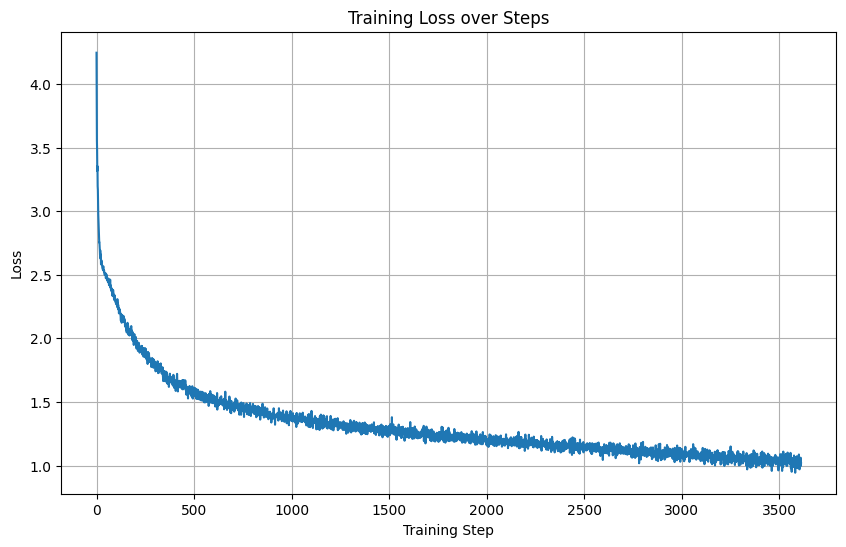

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()

In [88]:
# === Validation dataset + loader ===
val_batch_size = 8     # tune: how many samples on GPU at once (dataset returns batch-shaped tensors)
val_block_size = block_size
val_dataset = GPUBatchDataset(val_ids, val_block_size, val_batch_size, device, pad_len=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)  # dataset already returns batch-shaped tensors

# === Eval function ===
import math
import torch.nn.functional as F

def evaluate_model(model, val_loader, eval_iters=None, device=device):
    """
    Evaluate model over `eval_iters` batches from val_loader (if None: full val loader).
    Returns average loss (float).
    """
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in val_loader:

          logits, loss = model(xb[0], yb[0])
          losses.append(float(loss.item()))

          if eval_iters is not None and len(losses) >= eval_iters:
              break

    model.train()
    if len(losses) == 0:
        return float('nan')
    return float(sum(losses) / len(losses))

# === Run validation ===
# Quick eval over e.g. 50 validation batches (adjust as desired)
val_loss = evaluate_model(model, val_loader, eval_iters=50)
print(f"Validation loss (avg over 50 batches): {val_loss:.4f}")

# Or run over the entire val set (slower)
# val_loss_full = evaluate_model(model, val_loader, eval_iters=None)
# print(f"Validation loss (full val set): {val_loss_full:.4f}")

# Optionally compute perplexity
val_ppl = math.exp(val_loss) if not math.isinf(val_loss) else float('inf')
print(f"Validation perplexity (approx): {val_ppl:.4f}")

Validation loss (avg over 50 batches): 1.7040
Validation perplexity (approx): 5.4960


In [89]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=8192,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)

ROMEO:
I lay, my humours: and which rise prize,
It talk on all with us: I my leave a slain.

This bayss am fullow; yest stindesteem:
Mast; the mork voice: I have more come man?

PETRUCHIO:
Ay, on the gallant-waves Claudio taunts,
As you have on to vencaster, that we you dic,
May encerripe, and say you covether off.

BENVOLIO:
Stay your dwess'd, bring about, she
hatten our foes at the prettiest do here.

ESCALUS:
Love, away: he is before: yet they will do.

Messenger:
And I have good morrow she has done, and tood couldsward;
Once, sir, you have pay your adventure
Henry little will to use.

ESCALUS:
any good day.

FROLAN:
Ay, ta' the choice!

ELBOW:
WAy nondron.

SICINIUS:
You play he will hear him now; but insolation, I'll enter your walls.

ABOTHUMERLAND:
I shout you him nigh, you have know your heart out,
As if brotherhoyed as himself beloved him;
Lest for a nobility,--sort are my concerns plain;
Notion, V: because hyoung fair body's velve!

Clown:
So close, true! O sGones!

MENENIUS:

In [90]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.0001
)

print(generated)

ROMEO:
O ROLENG:
O God deny the prince that the orade
Of wither the prince that would speak their seat stin stin seckerthy secke them.

CLIFFORD:
An I'll to the people fitted by the state,
The world for some other rearming stain
As enemy the worldiverch our fresrate,
And the sea, and the sea root of him.

ROMEO:
And therefore the seat of the princes have seen
so long shall be so study in all allest me,
And he shall have the world and speak a present
Than the seals of their spirits of his life,
And then the seal of distress and here are not.

KING RICHARD III:
Then we have spent against your stain thee.

QUEEN ELIZABETH:
And then I were said, and make haste,
The law hath best a present death,
And he should be hus a traitor of his presence
Than the seal of death and deserves it that
Be solel, and you shall have you are a bands
And send him that you will reve away.

CLAUDIO:
I would they have a languance and your common
penalty and your honour and his lipp'd his lands,
and the air on my s

In [93]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=2.5
)

print(generated)

ROMEO:
AJSPAT:TINo, IO,;--
W PThioh,<unk>LeO
Tmap!
Oh,lgoy;ou', wall:
prief Roverlover,!No!
AngscomXtXUet,Herule,
INAO:
TrOLLOUARk

Thnrtok,UMBlusnd;
Cwape timGorneTmurders bRain:
ELnsby-came?

DUCmoFher.then'd,eo; Somour'ds die:
Trembthins!'
Bield foute, ES3WhNowaluous C:C,re,
thus st ethamWarwicvcoving bleckedn-a-tchilshs!'
Alaume!
Stop? aadops look;
Devour can.! time equaIPritevablock liza you.You, ifr
Your, hold'st MABY:
'GFive you, AhZbetter; mock'st you, Rutabler!
Voicinix!-juiMO?aked tRixen-whzhick.
Beins of Hereford, 'tis motheBiddgeds hundred, you-jest-haFore hire;
Make nine, or'sely nor,s,' ank,-:hominhoofty, way?evoleht!

NO'leoulkeld-careiugrcexQuln.
When, arty,-the hugh alone; or, for PerbewaHathing?
I's hce I apitufre rich
Of Pis:-Pomce
Alas,vise. Wte-missasa ITEDSWAY N':
RogeZned, gi.
Lewisgly, hunktcher, I cour't,
Now, his nhose
Of Yowars, alieewe tdee:
builIh madZo:'
Listsin
BXritomfetf'r Y BolYfulfful quicky; hhgWed

MIUMIse!'ze hneWhat's  you, telm keewhing MO3K:
3
h

In [86]:
torch.save(model,"model.pth")